# Introduction to Machine Learning: Competition

Project work by Antonio Padalino, Martina Arturi, Anna Culpo, Davide Longo from Indecisive Trees squad.

The objective of the project - as taken from the assignment paper - was to
*create an image search engine where a query image is fed to a model that will return the most N similar images from a gallery.*
This is known in literature as a content-based image retrieval system (CBIR) or, more precisely, as a similarity-based retrieval system.

Here's our attempt at it.


In [ ]:
# general use imports
import os
import json
import random
import numpy as np
from numpy.linalg import norm

# tensorflow
from tensorflow.keras import layers, Sequential
from tensorflow.keras.applications.resnet import ResNet152, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow.keras.backend as K
import tensorflow as tf

# sklearn
from sklearn.neighbors import NearestNeighbors

# utils
from tqdm import tqdm

# plotting
from matplotlib import rcParams
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [3]:
# Just listing available devices to use with tensorflow

print('Available devices:')
for device in tf.config.list_physical_devices():
    print(device)

Available devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## 1. Data preparation

Before diving into the making of our Neural Networks, here's some data preparation.
Here we are both (1) defining a class to handle and import our datasets from their paths and (2) defining a function to augment our images.

In [5]:
# To handle directories

class Dataset(object):

    def __init__(self, data_path):
        self.data_path = data_path
        assert os.path.exists(self.data_path), 'Insert a valid path!'

        # get class list
        self.data_classes = os.listdir(self.data_path)

        # init mapping dict
        self.data_mapping = {}

        # populate mapping dict
        for c, c_name in enumerate(self.data_classes):
            temp_path = os.path.join(self.data_path, c_name)
            temp_images = os.listdir(temp_path)

            for i in temp_images:
                img_tmp = os.path.join(temp_path, i)

                if img_tmp.lower().endswith(('.jpg', '.jpeg')):
                    if c_name == 'distractor':
                        self.data_mapping[img_tmp] = -1
                    else:
                        self.data_mapping[img_tmp] = c_name

        print(f'Loaded {len(self.data_mapping.keys())} from {self.data_path} images')

    def get_data_paths(self):
        # returns a list of img paths and related classes
        images = []
        classes = []
        for img_path in self.data_mapping.keys():
            if img_path.lower().endswith(('.jpg', '.jpeg')):
                images.append(img_path)
                classes.append(self.data_mapping[img_path])
        return images, np.array(classes)

    def num_classes(self):
        # returns number of classes of the dataset
        return len(self.data_classes)

# define paths for all folders
data_path = 'dataset'
training_path = os.path.join(data_path, 'training')
validation_path = os.path.join(data_path, 'validation')
gallery_path = os.path.join(validation_path, 'gallery')
query_path = os.path.join(validation_path, 'query')

# create 'Dataset' objects for each folder
training_dataset = Dataset(training_path)
gallery_dataset = Dataset(gallery_path)
query_dataset = Dataset(query_path)

# get training/gallery/query data paths and classes
training_paths, training_classes = training_dataset.get_data_paths()
gallery_paths, gallery_classes = gallery_dataset.get_data_paths()
query_paths, query_classes = query_dataset.get_data_paths()

Loaded 15000 from dataset/training images
Loaded 4800 from dataset/validation/gallery images
Loaded 600 from dataset/validation/query images


Natively, the given dataset contains 2500 training images, 800 gallery images and 100 query images.
For each of the 10 classes, the training folder contains 130 images.

To make better use of the training dataset, we discussed some way to extend it.

**More images from ImageNet**

It is known that the images for the competition are taken from ImageNet, one of the largest visual database designed for use in visual object recognition software research, containing more than 14 million images from more than 20,000 categories.
That being said, one could go beyond the 130 initial images and directly download images from ImageNet to start expanding our training dataset.

It is no easy task though: the dataset is quite large (~150GB) and downloading it all just for some more images from 10 classes would have been a waste of effort. Fortunately, ImageNet offers APIs to interact with the database, and a nice python script found on github (https://github.com/skaldek/ImageNet-Datasets-Downloader) made it even easier: just with the id of the class and the wanted number of images, we easily downloaded in bulk more images for our classes!

However, not every class from ImageNet contains the same number of images. We wanted to go up to 500 images per class at first, but to make things more balanced we went for 250 per class in the end (class `n01644900` had no more than 250 images).

**Image agugmentation**

Another useful step was data augmentation. generally used both to expand a dataset when too small and to reduce overfitting when training a NN. We realized it through an `ImageDataGenerator()` and a simple functions which returns *n* augmented copies of a given image.


In [6]:
# Augment training data

def augment_img(img_path, n):
    '''
    Create n randomly augmented copies of a given image and save them in the same folder
    :param img_path: path of the image to augment
    :param n: number of randomly augmented copies of the image needed
    :return: None
    '''
    data_aug = ImageDataGenerator(  # all augmentations we may perform
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    img = load_img(img_path)  # load as a PIL image
    arr_img = img_to_array(img)  # convert to a Numpy array with shape (3, 150, 150)
    exp_img = arr_img.reshape((1,) + arr_img.shape)  # add one more dim. to the shape, now (1, 3, 150, 150)

    cur_dir = os.path.dirname(img_path)  # current img directory

    prev_len = len(os.listdir(cur_dir))  # number of element current img directory

    cur_len = prev_len

    while cur_len - prev_len != n:  # until n new imgs are successfully created
        next(
            data_aug.flow(exp_img,
                          batch_size=1,
                          save_to_dir=cur_dir,
                          save_prefix='aug',
                          save_format='jpg')
        )

        cur_len = len(os.listdir(cur_dir))

done = True

for paths in [training_paths, gallery_paths, query_paths]:

    # for each img of each class we're adding 5 more randomly augmented copies

    if done: break

    for img_path in tqdm(paths, desc='Augmenting images'):
        augment_img(img_path, 5)


Here augmentation happens before even building our model, meaning that we pick every training image, create *n* slightly modified copies, and save them in the same directory. Is it something that we just need to run once, and here it has already been done.

One last step is the preparation of training data.

In order to use the training dataset to train our CNNs we used the function  `image_dataset_from_directory()` from `tf.keras.utils`. Also notice that The train/validation partitions are both taken from the training dataset, since we don't want to handle the gallery and query sets just yet: they will be used at a later time, when building our search engine.

In [8]:
# Prepare and split training data

train_ds = tf.keras.utils.image_dataset_from_directory(
    training_path,
    labels='inferred',
    validation_split=0.2,
    subset="training",
    color_mode="rgb",
    seed = 99,
    shuffle = True,
    image_size=(224, 224),
    batch_size=16
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    training_path,
    labels='inferred',
    validation_split=0.2,
    subset="validation",
    color_mode="rgb",
    seed = 99,
    shuffle = True,
    image_size=(224, 224),
    batch_size=16
)

Found 15000 files belonging to 10 classes.
Using 12000 files for training.
Found 15000 files belonging to 10 classes.
Using 3000 files for validation.


## 2. Building the Neural Network

For the purpose of this competition, we tried a number of approaches, both using Neural Networks (building a CNN from scratch and using a ResNet as backbone) and without (SIFT and ORB feature extraction + kNN). In this Notebook, we're going to provide an overview of the two approaches which included the use of Networks.

### 2.1 ResNet152

First we explored the Transfer Learning approach, using a pre-trained model with some due adjustments.

We considered using a Residual Neural Network as backbone, in this case ResNet152, imported from Keras without the classifier on top (notice the `include_top=False`), to avoid classifying on the whole ImageNet classes. Then we added a number of layers on top to build *our* classifier:
- a *Flatten* layer, which reduces the input dimensions, flattening the feature map returned by ResNet152
- a *Dense* layer, with number of neurons equal to the number of classes used for the competition (10), in other words, our classifier
- a *Dropout* layer, which helps preventing overfitting

**Why ResNet152?**

We also considered using *ResNet50* or *ResNet100*, but *ResNet152* is reportedly [https://arxiv.org/abs/1512.03385] the Residual NN with the least top-1 and top-5 error rates compared to other shallow ResNet models for classification on Imagenet validation.

In [15]:
# Save time and load it!

# model1 = tf.keras.models.load_model('saved_models/model1')

In [23]:
# Initialize the ResNet152 backbone without classifier

resnet = ResNet152(weights='imagenet',  # we use the weights from its past training on ImageNet!
                   include_top=False,  # top not included means no classifier on top!
                   input_shape=(224, 224, 3))

# Freeze the first 4 convolutional blocks

for layer in resnet.layers:
    if 'conv5' in layer.name:
        break
    layer.trainable = False

# Create our classifier on top of it

inputs = tf.keras.Input(shape=(224, 224, 3))
x = resnet(inputs, training=False)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(10, activation='softmax', kernel_regularizer='l1_l2')(x)
outputs = layers.Dropout(0.1, seed=999)(x)

model1 = tf.keras.Model(inputs, outputs)

model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 10)                1003530   
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
Total params: 59,374,474
Trainable params: 15,979,530
Non-trainable params: 43,394,944
_________________________________________________________________


We adopted an `EarlyStopping` callback to optimize our training phase by both reducing overfitting and reduce training times.

In [22]:
K.clear_session()

In [24]:
# Compile and fit the model

model1.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3)

history = model1.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[early_stop])

Epoch 1/50


2022-05-17 23:43:16.518257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - ETA: 0s - loss: 34.2149 - accuracy: 0.7333

2022-05-17 23:46:00.946441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - 205s 267ms/step - loss: 34.2149 - accuracy: 0.7333 - val_loss: 27.5408 - val_accuracy: 0.9443
Epoch 2/50
750/750 [==============================] - 197s 263ms/step - loss: 22.7160 - accuracy: 0.8966 - val_loss: 17.8990 - val_accuracy: 0.9527
Epoch 3/50
750/750 [==============================] - 197s 262ms/step - loss: 14.1173 - accuracy: 0.9044 - val_loss: 10.5875 - val_accuracy: 0.9633
Epoch 4/50
750/750 [==============================] - 197s 263ms/step - loss: 8.2732 - accuracy: 0.9110 - val_loss: 6.0674 - val_accuracy: 0.9650
Epoch 5/50
750/750 [==============================] - 197s 263ms/step - loss: 4.8572 - accuracy: 0.9077 - val_loss: 3.6540 - val_accuracy: 0.9627
Epoch 6/50
750/750 [==============================] - 196s 262ms/step - loss: 2.9341 - accuracy: 0.9140 - val_loss: 2.2628 - val_accuracy: 0.9710
Epoch 7/50
750/750 [==============================] - 197s 262ms/step - loss: 1.9407 - accuracy: 0.9106 - val_loss: 1.4498 - val_

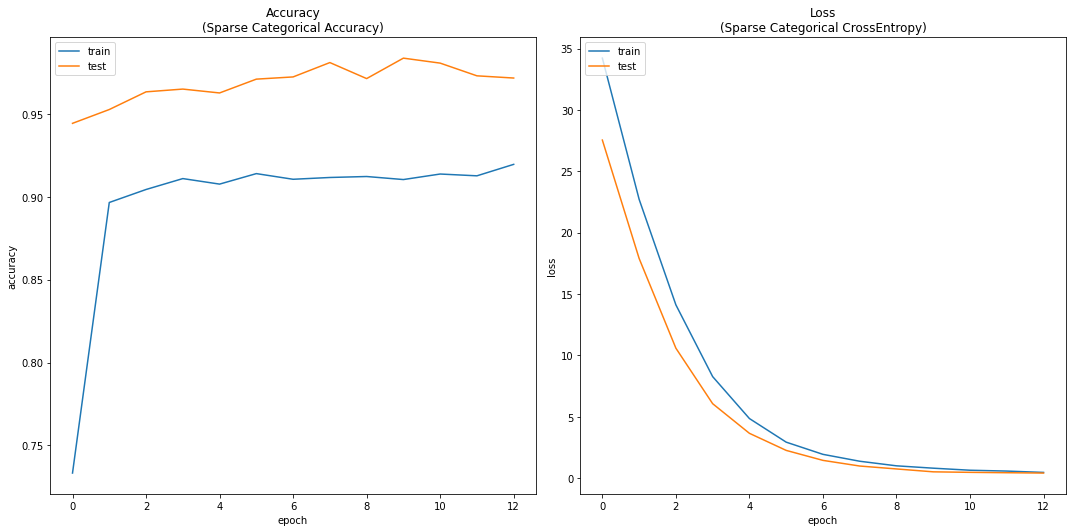

In [31]:
# Plot model training history

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7.5))

axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Accuracy\n(Sparse Categorical Accuracy)')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'test'], loc='upper left')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Loss\n(Sparse Categorical CrossEntropy)')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['train', 'test'], loc='upper left')

fig.tight_layout()
plt.show()

After the training phase, the classifier has been removed again: our model should stop at feature extraction, with no classifying.

In [27]:
# Removing the classifier - we just need the feature extractor

features = model1.get_layer('flatten').output

model1 = tf.keras.Model(model1.inputs, features)

model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
Total params: 58,370,944
Trainable params: 14,976,000
Non-trainable params: 43,394,944
_________________________________________________________________


In [29]:
# model1.save('saved_models/model1')

2022-05-18 07:05:41.830405: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_models/model1/assets


### 2.2 Built-from-scratch CNN

We also wanted to experiment first-hand with building a Convolutional NN, taking inspiration from other architectures.


In [33]:
# Save time and load it!

# model2 = tf.keras.models.load_model('saved_models/model2')

In [ ]:
model2 = Sequential([

    layers.InputLayer(input_shape=(224,224,3)),

    layers.Conv2D(8,(7,7),strides=(3,3),activation='relu',kernel_regularizer='l1_l2'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Conv2D(16,(3,3),strides=(2,2),activation='relu',kernel_regularizer='l1_l2'),
    layers.BatchNormalization(),
    layers.Conv2D(16,(3,3),strides=(1,1),activation='relu',kernel_regularizer='l1_l2'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Conv2D(32,(3,3),strides=(2,2),activation='relu',kernel_regularizer='l1_l2'),
    layers.BatchNormalization(),
    layers.Conv2D(32,(3,3),strides=(1,1),activation='relu',kernel_regularizer='l1_l2'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.AvgPool2D(2,2),
    layers.Flatten(name='flatten_layer'),

    layers.Dense(10, activation='softmax',kernel_regularizer='l1_l2'),
    layers.Dropout(0.2)

])

Again, we adopted callbacks such as `ReduceLROnPlateau` and `EarlyStopping` to optimize our training phase.

In [36]:
K.clear_session()

In [38]:
# Compile and fit model specifying the most appropriate loss and metrics

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=5)

model2.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               metrics=['accuracy'])


history = model2.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[reduce_lr, early_stop])

Epoch 1/50


2022-05-18 07:09:06.171555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


748/750 [============================>.] - ETA: 0s - loss: 24.6751 - accuracy: 0.1115

2022-05-18 07:09:20.109630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - 18s 23ms/step - loss: 24.6742 - accuracy: 0.1116 - val_loss: 21.0198 - val_accuracy: 0.1433 - lr: 1.0000e-05
Epoch 2/50
750/750 [==============================] - 16s 21ms/step - loss: 23.6730 - accuracy: 0.1371 - val_loss: 20.1182 - val_accuracy: 0.1773 - lr: 1.0000e-05
Epoch 3/50
750/750 [==============================] - 15s 19ms/step - loss: 22.7822 - accuracy: 0.1657 - val_loss: 19.2545 - val_accuracy: 0.2123 - lr: 1.0000e-05
Epoch 4/50
750/750 [==============================] - 13s 18ms/step - loss: 22.0348 - accuracy: 0.1869 - val_loss: 18.4129 - val_accuracy: 0.2400 - lr: 1.0000e-05
Epoch 5/50
750/750 [==============================] - 14s 19ms/step - loss: 21.1991 - accuracy: 0.2105 - val_loss: 17.6096 - val_accuracy: 0.2493 - lr: 1.0000e-05
Epoch 6/50
750/750 [==============================] - 14s 18ms/step - loss: 20.3545 - accuracy: 0.2255 - val_loss: 16.8161 - val_accuracy: 0.2567 - lr: 1.0000e-05
Epoch 7/50
750/750 [=============

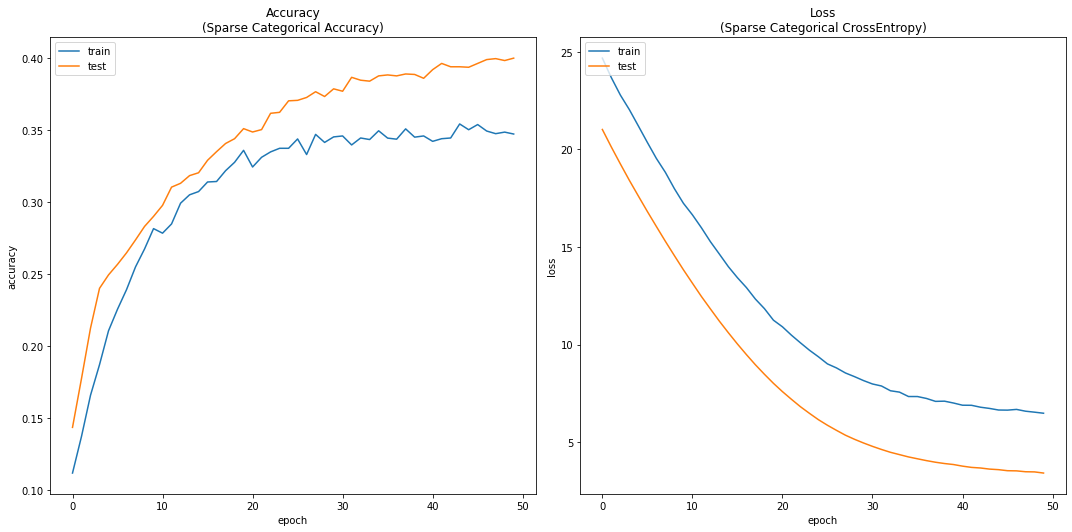

In [39]:
# Plot model training history

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7.5))

axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Accuracy\n(Sparse Categorical Accuracy)')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'test'], loc='upper left')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Loss\n(Sparse Categorical CrossEntropy)')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['train', 'test'], loc='upper left')

fig.tight_layout()
plt.show()

Again, we removed the final layers (classifier), to make our model predict just a vector of features.

In [40]:
# Cutting our model

features = model2.get_layer("flatten_layer").output

model2 = tf.keras.Model(model2.inputs, features)

model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 73, 73, 8)         1184      
                                                                 
 batch_normalization (BatchN  (None, 73, 73, 8)        32        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 73, 73, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 36, 16)        1168      
                                                                 
 batch_normalization_1 (Batc  (None, 36, 36, 16)       64        
 hNormalization)                                             

In [77]:
# model2.save('saved_models/model2')

INFO:tensorflow:Assets written to: saved_models/model2/assets


## 3. Image search and evaluation

Now that our models have been built and trained, we can talk about the actual image search.

But before going further, it is useful to define a function to preprocess an image (from its path) and fed it to the `model.predict()`.

We adapted the one seen in class:

In [42]:
# Extract features from test images

def extract_features(img_path, model):
    '''
    Preprocess an image and fed it into the model
    :param img_path: path of the image to fed to the model
    :param model: the actual model the function will use
    :return: a vector of normalized predictions or features
    '''
    # prepare image before model.predict()
    input_shape = (224, 224, 3)
    img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    # now we can .predict()
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

Extract features using our first model, ResNet152:

In [78]:
gallery_feats = list()
query_feats = list()

model = model1  # let's use ResNet152

for i in tqdm(range(len(gallery_paths)), desc='Extracting gallery set features\t '):
    gallery_feats.append(extract_features(gallery_paths[i], model))

for i in tqdm(range(len(query_paths)), desc='Extracting query set features\t '):
    query_feats.append(extract_features(query_paths[i], model))

Extracting query set features	 : 100%|██████████| 600/600 [00:32<00:00, 18.21it/s]




The following functions are quite self explanatory. You can refer to their docstrings for more infos.

In [73]:
# make a query-gallery search and evaluate it
def make_query(i, quiet=False, return_dict=False):
    '''
    Given a query image, retrieve the 10 most similar images in gallery and return top1, top3 and top5 accuracy

    :param i: the index of the query image to pick
    :param quiet: if True doesn't show labels of query/gallery images and the hit/miss symbols
    :param visual: if True displays the queried image and the 10 most similar ones
    :return: top1, top3 and top5 accuracy of given query-image search & a dict with key: query images names
             and value: list of fetched images sorted by similarity
    '''

    kNN_model = NearestNeighbors(n_neighbors=10, algorithm='brute', metric='euclidean')
    neighbors = kNN_model.fit(gallery_feats)

    dists, ids = neighbors.kneighbors([query_feats[i]])

    query_lab = query_dataset.data_mapping[query_paths[i]]

    if not quiet:

        plt.imshow(mpimg.imread(query_paths[i]))
        plt.title('Queried image', {'color': 'white'})  # for dark mode!
        plt.axis('off')

        plt.show()

        rcParams['figure.figsize'] = 15, 5

        f, axarr = plt.subplots(2, 5)

        n = 0
        for r in range(2):
            for c in range(5):
                axarr[r, c].imshow(mpimg.imread(gallery_paths[ids[0][n]]))
                axarr[r, c].axis('off')
                n += 1

        plt.show()

        print(f'Queried img:\n{query_lab}')
        print('\nRetrieved imgs:')

    matches = list()

    cur_key = gallery_paths[i].split('/')[-1]

    ret = {cur_key: []}

    for ind in ids[0]:

        gallery_lab = gallery_dataset.data_mapping[gallery_paths[ind]]

        ret[cur_key].append(gallery_paths[ind].split('/')[-1])

        if query_lab == gallery_lab:
            matches.append(True)
            if not quiet:
                print(gallery_lab, '○')
        else:
            matches.append(False)
            if not quiet:
                print(gallery_lab, '✕')

    top1acc, top3acc, top5acc, top10acc = any(matches[:1]), any(matches[:3]), any(matches[:5]), any(matches[:10])

    if return_dict:
        return ret

    else:
        return top1acc, top3acc, top5acc, top10acc


# perform evaluation on the whole query dataset
def evaluation(as_json=False, filename='results'):
    '''
    Perform a silent make_query() on all query images and either print the mean top1, top3 and top5 accuracy
    or return a json file mapping query images and retrieved images sorted by similarity
    :return: None
    '''

    all_t1, all_t3, all_t5, all_t10 = list(), list(), list(), list()

    ret = {'group_name': 'IndecisiveTrees',
           'queries': []}

    for i in tqdm(range(len(query_feats)), desc='Testing on all queries'):

        t1, t3, t5, t10 = make_query(i, quiet=True)

        all_t1.append(t1)
        all_t3.append(t3)
        all_t5.append(t5)
        all_t10.append(t10)

        if as_json:
            cur_dict = make_query(i, quiet=True, return_dict=True)
            ret['queries'].append(cur_dict)

    print('RESULTS:')
    print(f'top-1  accuracy: {round(np.mean(all_t1), 4)}')
    print(f'top-3  accuracy: {round(np.mean(all_t3), 4)}')
    print(f'top-5  accuracy: {round(np.mean(all_t5), 4)}')
    print(f'top-10 accuracy: {round(np.mean(all_t10), 4)}')

    if as_json:
        with open(filename, 'w') as f:
            json.dump(ret, f)

Let's try querying a random i-th image from query:

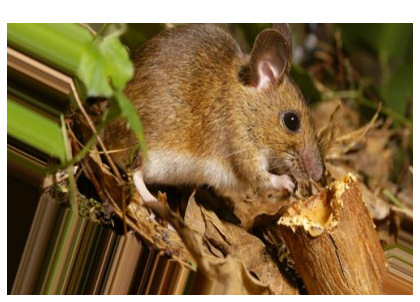

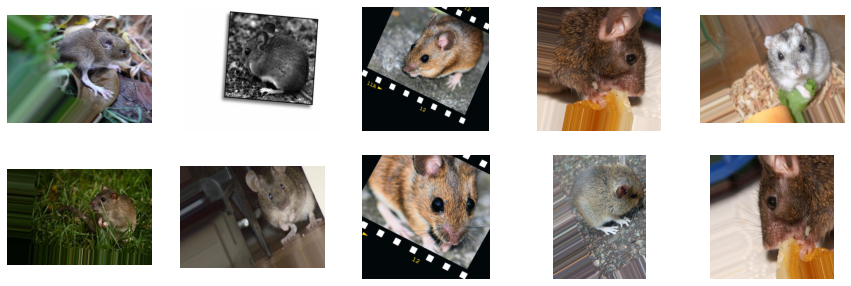

Queried img:
n02330245(mouse)

Retrieved imgs:
n02330245(mouse) ○
n02330245(mouse) ○
n02330245(mouse) ○
n02330245(mouse) ○
n02330245(mouse) ○
n02330245(mouse) ○
n02330245(mouse) ○
n02330245(mouse) ○
n02330245(mouse) ○
n02330245(mouse) ○


(True, True, True, True)

In [79]:
i = random.randint(1,99)

make_query(i)

## 4. Model evaluation

Now for the 'real' evaluation, on all queries of the query dataset:

In [80]:
# How did ResNet152 score?

evaluation(as_json=True, filename='results_model1.json')  # to also save results as .json file

Testing on all queries: 100%|██████████| 600/600 [41:46<00:00,  4.18s/it]

RESULTS:
top-1  accuracy: 0.9383
top-3  accuracy: 0.9533
top-5  accuracy: 0.955
top-10 accuracy: 0.96


Lastly, let's re-extract features using `model2` this time and re-compute accuracies:

In [47]:
gallery_feats = list()
query_feats = list()

model = model2  # let's use our built-from-scratch model this time

for i in tqdm(range(len(gallery_paths)), desc='Extracting gallery set features\t '):
    gallery_feats.append(extract_features(gallery_paths[i], model))

for i in tqdm(range(len(query_paths)), desc='Extracting query set features\t '):
    query_feats.append(extract_features(query_paths[i], model))

Extracting query set features	 : 100%|██████████| 600/600 [00:13<00:00, 44.67it/s]


In [48]:
# How did our model score?

evaluation(as_json=True, filename='results_model2.json')  # to also save results as .json file

Testing on all queries: 100%|██████████| 600/600 [00:20<00:00, 28.88it/s]

RESULTS:
top-1  accuracy: 0.17
top-3  accuracy: 0.3983
top-5  accuracy: 0.51
top-10 accuracy: 0.6367


Pretty bad in comparison with the previous model based on ResNet. Probably due to:
- the small size of our dataset (ResNet is trained on ImageNet, on more than 14 mil images, versus our 15000)
- the quite simple architecture

In a sense, we might have been expected that.

Thank you! ✿